In [61]:
import sqlalchemy as sql
import pandas as pd
import glob
from os import path, sep
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from scipy.signal import oaconvolve
from scipy.signal import remez

import decimate as d
from importlib import reload
reload(d);

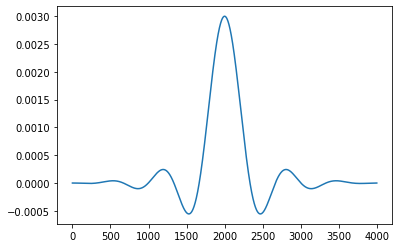

In [4]:
f3 = remez(4000,[0., 0.5, 1., 250.],[1.,0.],fs=500)
plt.plot(f3[1:-1])


In [5]:
server = "thesis.ca6j6heoraog.eu-central-1.rds.amazonaws.com"
engine = sql.create_engine(f"mysql+pymysql://admin:FphvsYQek4@{server}/thesis_db")


In [7]:
con = engine.connect()

In [8]:
stmnt = """
SELECT participant_id,
       data_ordinal,
       data_time,
       data_time_diff
FROM   raw_interval_data
WHERE  participant_id = 123
       AND series_type_id = 2  
       """
df = pd.read_sql(stmnt, con)

In [9]:
df

,participant_id,data_ordinal,data_time,data_time_diff
0,123,0,0.510,NaN
1,123,1,1.388,0.878
2,123,2,2.254,0.866
3,123,3,3.134,0.880
4,123,4,3.972,0.838
...,...,...,...,...
411,123,411,309.944,0.878
412,123,412,310.752,0.808
413,123,413,311.474,0.722
414,123,414,312.202,0.728


In [11]:
x = df.data_time.to_numpy()
y = df.data_time_diff.to_numpy()

x1 = np.zeros(len(x)*2-2)
x1[::2] = x[:-1]
x1[1::2] = x[:-1]
x1 = x1[1:-1]

y1 = np.zeros(len(y)*2-2)
y1[::2] = y[1:]
y1[1::2] = y[1:]

y1 = y1[:-2]

print(len(x1),len(y1))


828 828


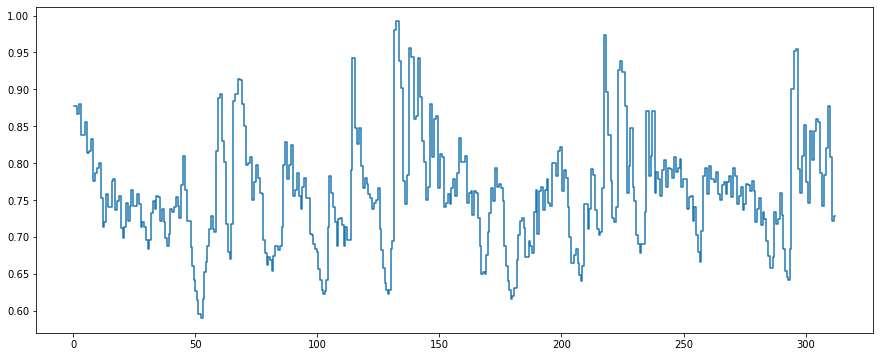

In [14]:
plt.figure(figsize=(15,6))
plt.plot(x1,y1)

In [66]:
x2 = x[:-1]
y2 = np.diff(x)
xd, yd = d.pw_constant_to_dense(x2, y2,np.arange(0.5,312.200,0.002))

(0.7, 0.75)

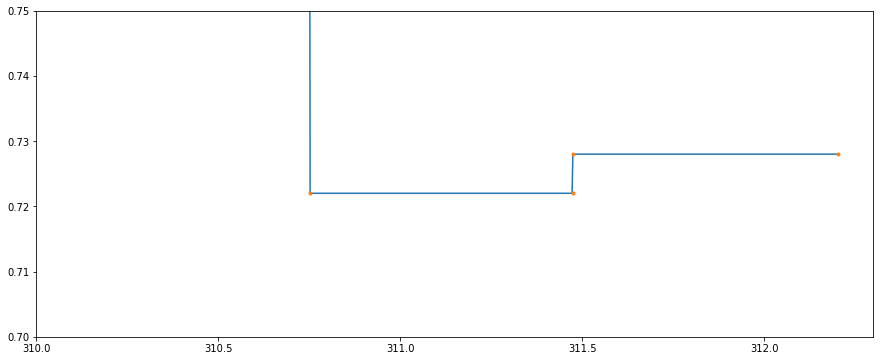

In [70]:
plt.figure(figsize=(15,6))
plt.plot(xd,yd)
plt.plot(x1,y1,'.')
plt.xlim(310., 312.3)
plt.ylim(0.7, 0.75)

In [89]:
y_oa = oaconvolve(yd, f3,'same')
x_pw = np.arange(0.51,313,0.25)
y_pw = d.pw_constant_convolve(x2, y2, 312.54, f3, 4, 4, x_pw )


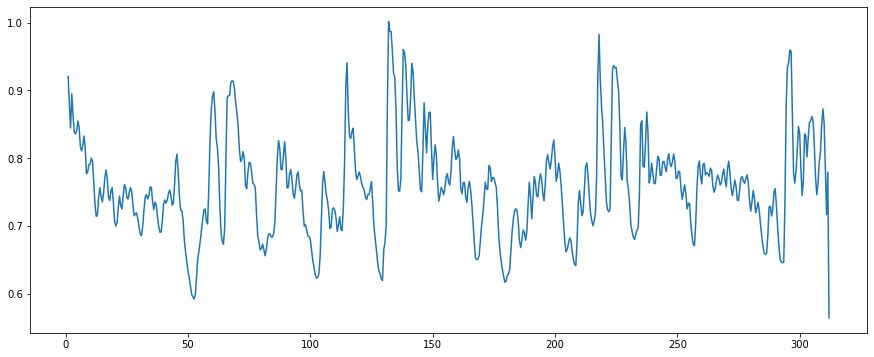

In [91]:
yi = y_oa[250::250]
xi = xd[250::250]
plt.figure(figsize=(15,6))
plt.plot(xi,yi)

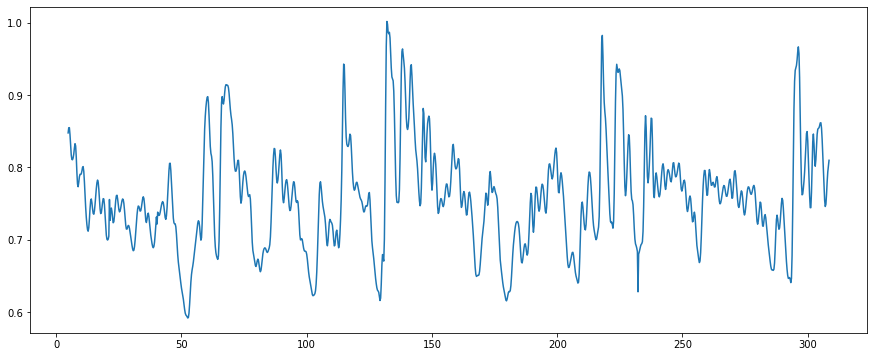

In [90]:
plt.figure(figsize=(15,6))
plt.plot(x_pw, y_pw)

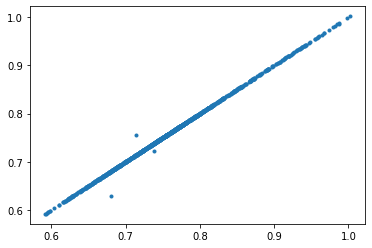

In [96]:
plt.plot(y_oa[::125],y_pw[0:-3],'.')

These 3 visible errors in the interpolation algorithm should be checked

In [87]:
xd[:5000:250]

array([ 0.51,  1.01,  1.51,  2.01,  2.51,  3.01,  3.51,  4.01,  4.51,
        5.01,  5.51,  6.01,  6.51,  7.01,  7.51,  8.01,  8.51,  9.01,
        9.51, 10.01])

In [85]:
x_pw[:5]

array([0.51, 1.01, 1.51, 2.01, 2.51])